In [1]:
#Figure of vertical RMSE - December 2021
#Choose a winter one and a summer one
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import gsw
import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

pathfig = '/home1/datawork/epauthen/Fig_Product/Figure_clean/'
os.getcwd()

'/home1/datahome/epauthen'

In [2]:
#RMSE function
def rmse_from_ae(ae):
    return np.sqrt(((ae) ** 2).mean(axis=0))

In [3]:
#Load the test one to compare with
#Adjust MLD first   
ds  = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OSnet_train_full/full_ds_adj.nc').load() #Bootstrap no sig
ds = ds.assign_coords(N_PROF=np.arange(1,len(ds.LONGITUDE)+1))
ds

<xarray.Dataset>
Dimensions:             (N_PROF: 67767, PRES_INTERPOLATED: 51, Model: 15)
Coordinates:
    LONGITUDE           (N_PROF) float64 -48.43 -47.55 -53.35 ... -61.67 -64.59
    LATITUDE            (N_PROF) float64 49.0 48.73 32.94 ... 43.15 41.81 31.53
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
    TIME                (N_PROF) datetime64[ns] 2001-08-08T06:20:53 ... 2000-...
  * N_PROF              (N_PROF) int64 1 2 3 4 5 ... 67764 67765 67766 67767
Dimensions without coordinates: Model
Data variables: (12/40)
    TEMP_SURF           (N_PROF, PRES_INTERPOLATED) float64 nan nan ... 6.925
    PSAL_SURF           (N_PROF, PRES_INTERPOLATED) float64 nan nan ... 35.03
    TEMP                (N_PROF, PRES_INTERPOLATED) float64 12.44 ... 6.925
    PSAL                (N_PROF, PRES_INTERPOLATED) float64 33.82 ... 35.03
    DC_REFERENCE        (N_PROF) |S8 b'25563' b'25590' ... b'51533584'
    PLATFORM_NUMBER     (N_PROF) |S8 b'4900190' b'4900191' ... b'AGOR'
    ...                  ...
    rmse_S_model        (Model, PRES_INTERPOLATED) float64 0.2938 ... 0.05287
    MLD_mask2           (N_PROF, PRES_INTERPOLATED) float32 0.007325 ... 1.0
    MLD_mask3           (N_PROF, PRES_INTERPOLATED) float32 0.007325 ... 1.0
    TEMP_adj            (N_PROF, PRES_INTERPOLATED) float64 12.19 ... 7.303
    PSAL_adj            (N_PROF, PRES_INTERPOLATED) float64 33.65 ... 35.12
    SIG_adj             (N_PROF, PRES_INTERPOLATED) float64 25.51 ... 27.49

In [4]:
#Compute OSnet RMSE adj
ae_T_adj = np.fabs(ds['TEMP']- ds['TEMP_adj'])
ae_S_adj = np.fabs(ds['PSAL']- ds['PSAL_adj'])
ae_SIG_adj = np.fabs(ds['SIG']- ds['SIG_adj'])
ds = ds.assign(variables={"ae_S_adj": (('N_PROF', 'PRES_INTERPOLATED'), ae_S_adj.data)})
ds = ds.assign(variables={"ae_T_adj": (('N_PROF', 'PRES_INTERPOLATED'), ae_T_adj.data)})

rmse_T = rmse_from_ae(ds['ae_T_adj'])
rmse_S = rmse_from_ae(ds['ae_S_adj'])
ds = ds.assign(variables={"rmse_T_adj": (('PRES_INTERPOLATED'), rmse_T.data)})
ds = ds.assign(variables={"rmse_S_adj": (('PRES_INTERPOLATED'), rmse_S.data)})

In [5]:
#Compute OSnet RMSE
ae_T_pred = np.fabs(ds['TEMP']- ds['TEMP_predicted'])
ae_S_pred = np.fabs(ds['PSAL']- ds['PSAL_predicted'])
ae_SIG_pred = np.fabs(ds['SIG']- ds['SIG_predicted'])
ds = ds.assign(variables={"ae_T_pred": (('N_PROF', 'PRES_INTERPOLATED'), ae_T_pred.data)})
ds = ds.assign(variables={"ae_S_pred": (('N_PROF', 'PRES_INTERPOLATED'), ae_S_pred.data)})

rmse_T = rmse_from_ae(ds['ae_T_pred'])
rmse_S = rmse_from_ae(ds['ae_S_pred'])
ds = ds.assign(variables={"rmse_T_pred": (('PRES_INTERPOLATED'), rmse_T.data)})
ds = ds.assign(variables={"rmse_S_pred": (('PRES_INTERPOLATED'), rmse_S.data)})

In [6]:
#Load the test one to compare with
ds_test  = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OSnet_test/test_ds.nc').load()
ds_train = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OSnet_test/train_ds.nc').load()
ds_train = ds_train.assign_coords(N_PROF=np.arange(1,len(ds_train.LONGITUDE)+1))
ds_test = ds_test.assign_coords(N_PROF=np.arange(1,len(ds_test.LONGITUDE)+1))


In [7]:
#Load GLORYS and ARMOR3D data
glorys = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/GLORYS_interp/GLORYS_aeCORAv3.nc')

#Compute GLORYS RMSE
rmse_T = rmse_from_ae(glorys['ae_T'])
rmse_S = rmse_from_ae(glorys['ae_S'])
glorys = glorys.assign(variables={"rmse_T": (('PRES_INTERPOLATED'), rmse_T.data)})
glorys = glorys.assign(variables={"rmse_S": (('PRES_INTERPOLATED'), rmse_S.data)})


In [8]:
#Load ARMOR3D interpolated on CORA
armor = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/ARMOR3D_93-18/ARMOR3D_aeCORAv3.nc')
#Compute ARMOR3D RMSE
rmse_T = rmse_from_ae(armor['ae_T'])
rmse_S = rmse_from_ae(armor['ae_S'])
armor = armor.assign(variables={"rmse_T": (('PRES_INTERPOLATED'), rmse_T.data)})
armor = armor.assign(variables={"rmse_S": (('PRES_INTERPOLATED'), rmse_S.data)})


In [1]:
#Vertical RMSE weighted by variance, to have the relative RMSE 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
(ds.rmse_T_adj*100/ds.TEMP.std(dim = 'N_PROF')).plot(y = "PRES_INTERPOLATED",yincrease = False,ax = ax[0])
(ds.rmse_S_adj*100/ds.PSAL.std(dim = 'N_PROF')).plot(y = "PRES_INTERPOLATED",yincrease = False,ax = ax[1])
ax[0].grid()
ax[1].grid()
ax[0].set_ylabel('Depth [m]')
ax[1].set_ylabel('')
ax[0].set_xlabel('%')
ax[1].set_xlabel('%')
ax[0].set_title('RMSE/std(temperature)')
ax[1].set_title('RMSE/std(salinity)')


NameError: name 'plt' is not defined

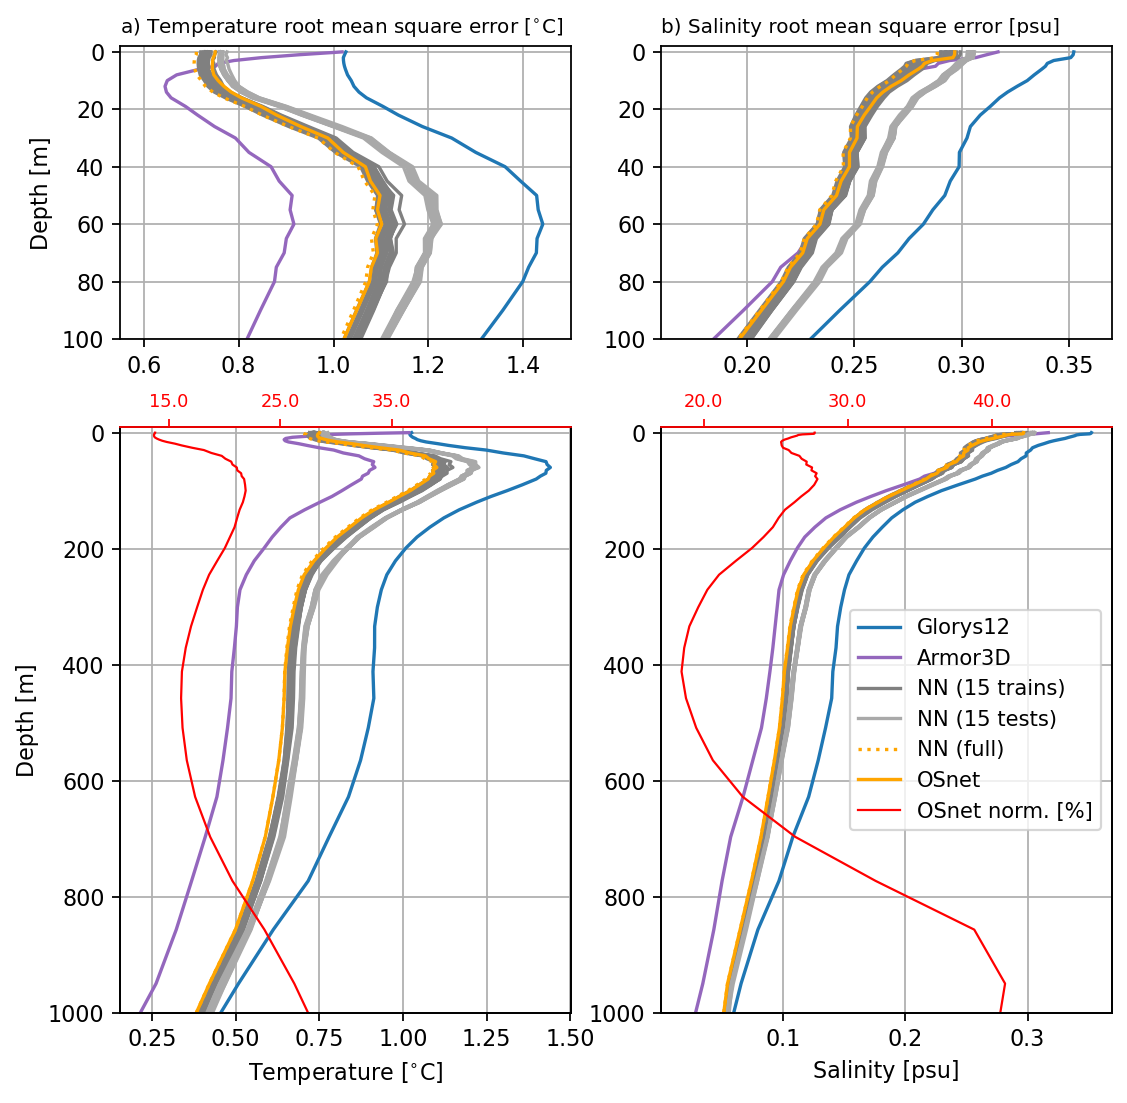

In [17]:
#Plot RMSE profiles
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), gridspec_kw={'height_ratios': [1, 2]}, dpi=160, facecolor='w', edgecolor='k')
dmax = [100,1000]
dmin = [-2,-10]

for l in np.arange(2):
    ax[l,0].plot(glorys.rmse_T, glorys.PRES_INTERPOLATED, label='Glorys12',c = 'tab:blue')
    ax[l,0].plot(armor.rmse_T, armor.PRES_INTERPOLATED, label='Armor3D',c = 'tab:purple')
    for m in np.arange(15):
        ax[l,0].plot(ds_train.rmse_T_model.isel(Model = m), ds_train.PRES_INTERPOLATED,c = 'grey')
        ax[l,0].plot(ds_test.rmse_T_model.isel(Model = m), ds_test.PRES_INTERPOLATED,c = 'darkgrey')
    ax[l,0].plot(ds.rmse_T_pred, ds.PRES_INTERPOLATED, label='NN (full)',linestyle = 'dotted',c = 'orange')
    ax[l,0].plot(ds.rmse_T_adj, ds.PRES_INTERPOLATED, label='OSnet',c = 'orange')
    ax[0,0].set_xlim([0.55,1.5])
    ax[l,0].set_ylim([dmax[l],dmin[l]])

    ax[l,1].plot(glorys.rmse_S, glorys.PRES_INTERPOLATED, label='Glorys12',c = 'tab:blue')
    ax[l,1].plot(armor.rmse_S, armor.PRES_INTERPOLATED, label='Armor3D',c = 'tab:purple')
    ax[l,1].plot(ds_train.rmse_S_model.isel(Model = 0), ds_train.PRES_INTERPOLATED, label='NN (15 trains)',c = 'grey')
    ax[l,1].plot(ds_test.rmse_S_model.isel(Model = 0), ds_test.PRES_INTERPOLATED, label='NN (15 tests)',c = 'darkgrey')
    for m in np.arange(1,15):
        ax[l,1].plot(ds_train.rmse_S_model.isel(Model = m), ds_train.PRES_INTERPOLATED,c = 'grey')
        ax[l,1].plot(ds_test.rmse_S_model.isel(Model = m), ds_test.PRES_INTERPOLATED,c = 'darkgrey')
    ax[l,1].plot(ds.rmse_S_pred, ds.PRES_INTERPOLATED, label='NN (full)',linestyle = 'dotted',c = 'orange')
    ax[l,1].plot(ds.rmse_S_adj, ds.PRES_INTERPOLATED, label='OSnet',c = 'orange')
    ax[l,1].set_ylim([dmax[l],dmin[l]])
    ax[0,1].set_xlim([0.16,0.37])

#Add normalized RMSE
(-.2+(ds.rmse_T_adj*100/ds.TEMP.std(dim = 'N_PROF'))/30).plot(y = "PRES_INTERPOLATED",linewidth = 1
                                                                        ,yincrease = False,ax = ax[1,0],c = "red")
axtop = ax[1,0].twiny()
nn = -.2+np.array([15,25,35])/30
#nn = np.array([0.25,0.5,0.75])
axtop.set_xlim(ax[1,0].get_xlim())
axtop.set_xticks(nn)
axtop.set_xticklabels(np.round((.2+nn)*30,0))
axtop.xaxis.label.set_color('red')       
axtop.tick_params(axis='x', colors='red') 
axtop.spines['top'].set_color('red')
axtop.xaxis.set_tick_params(labelsize=8)

(-.2+(ds.rmse_S_adj*100/ds.PSAL.std(dim = 'N_PROF'))/85).plot(y = "PRES_INTERPOLATED",linewidth = 1
                                                                        ,yincrease = False,ax = ax[1,1],c = "red",label = "OSnet norm. [%]")
axtop = ax[1,1].twiny()
nn = -.2+np.array([20,30,40])/85
#nn = np.array([0.1,0.2,0.3])
axtop.set_xlim(ax[1,1].get_xlim())
axtop.set_xticks(nn)
axtop.set_xticklabels(np.round((.2+nn)*85,0))
axtop.xaxis.label.set_color('red')       
axtop.tick_params(axis='x', colors='red') 
axtop.spines['top'].set_color('red')
axtop.xaxis.set_tick_params(labelsize=8)

ax[0,0].set_title('a) Temperature root mean square error [$^{\circ}$C]',fontsize = 9,loc = 'left')
ax[0,1].set_title('b) Salinity root mean square error [psu]',fontsize = 9,loc = 'left')
ax[1,0].set_xlabel('Temperature [$^{\circ}$C]')
ax[1,1].set_xlabel('Salinity [psu]')
ax[1,1].legend(loc = 'best', prop={'size': 9.5})
for t in np.arange(2):
    ax[t,0].set_ylabel('Depth [m]')
    for s in np.arange(2):
        ax[t,s].grid()
ax[1,1].set_ylabel('')

plt.savefig(pathfig + 'RMSEnorm.png', transparent=False)
plt.show()

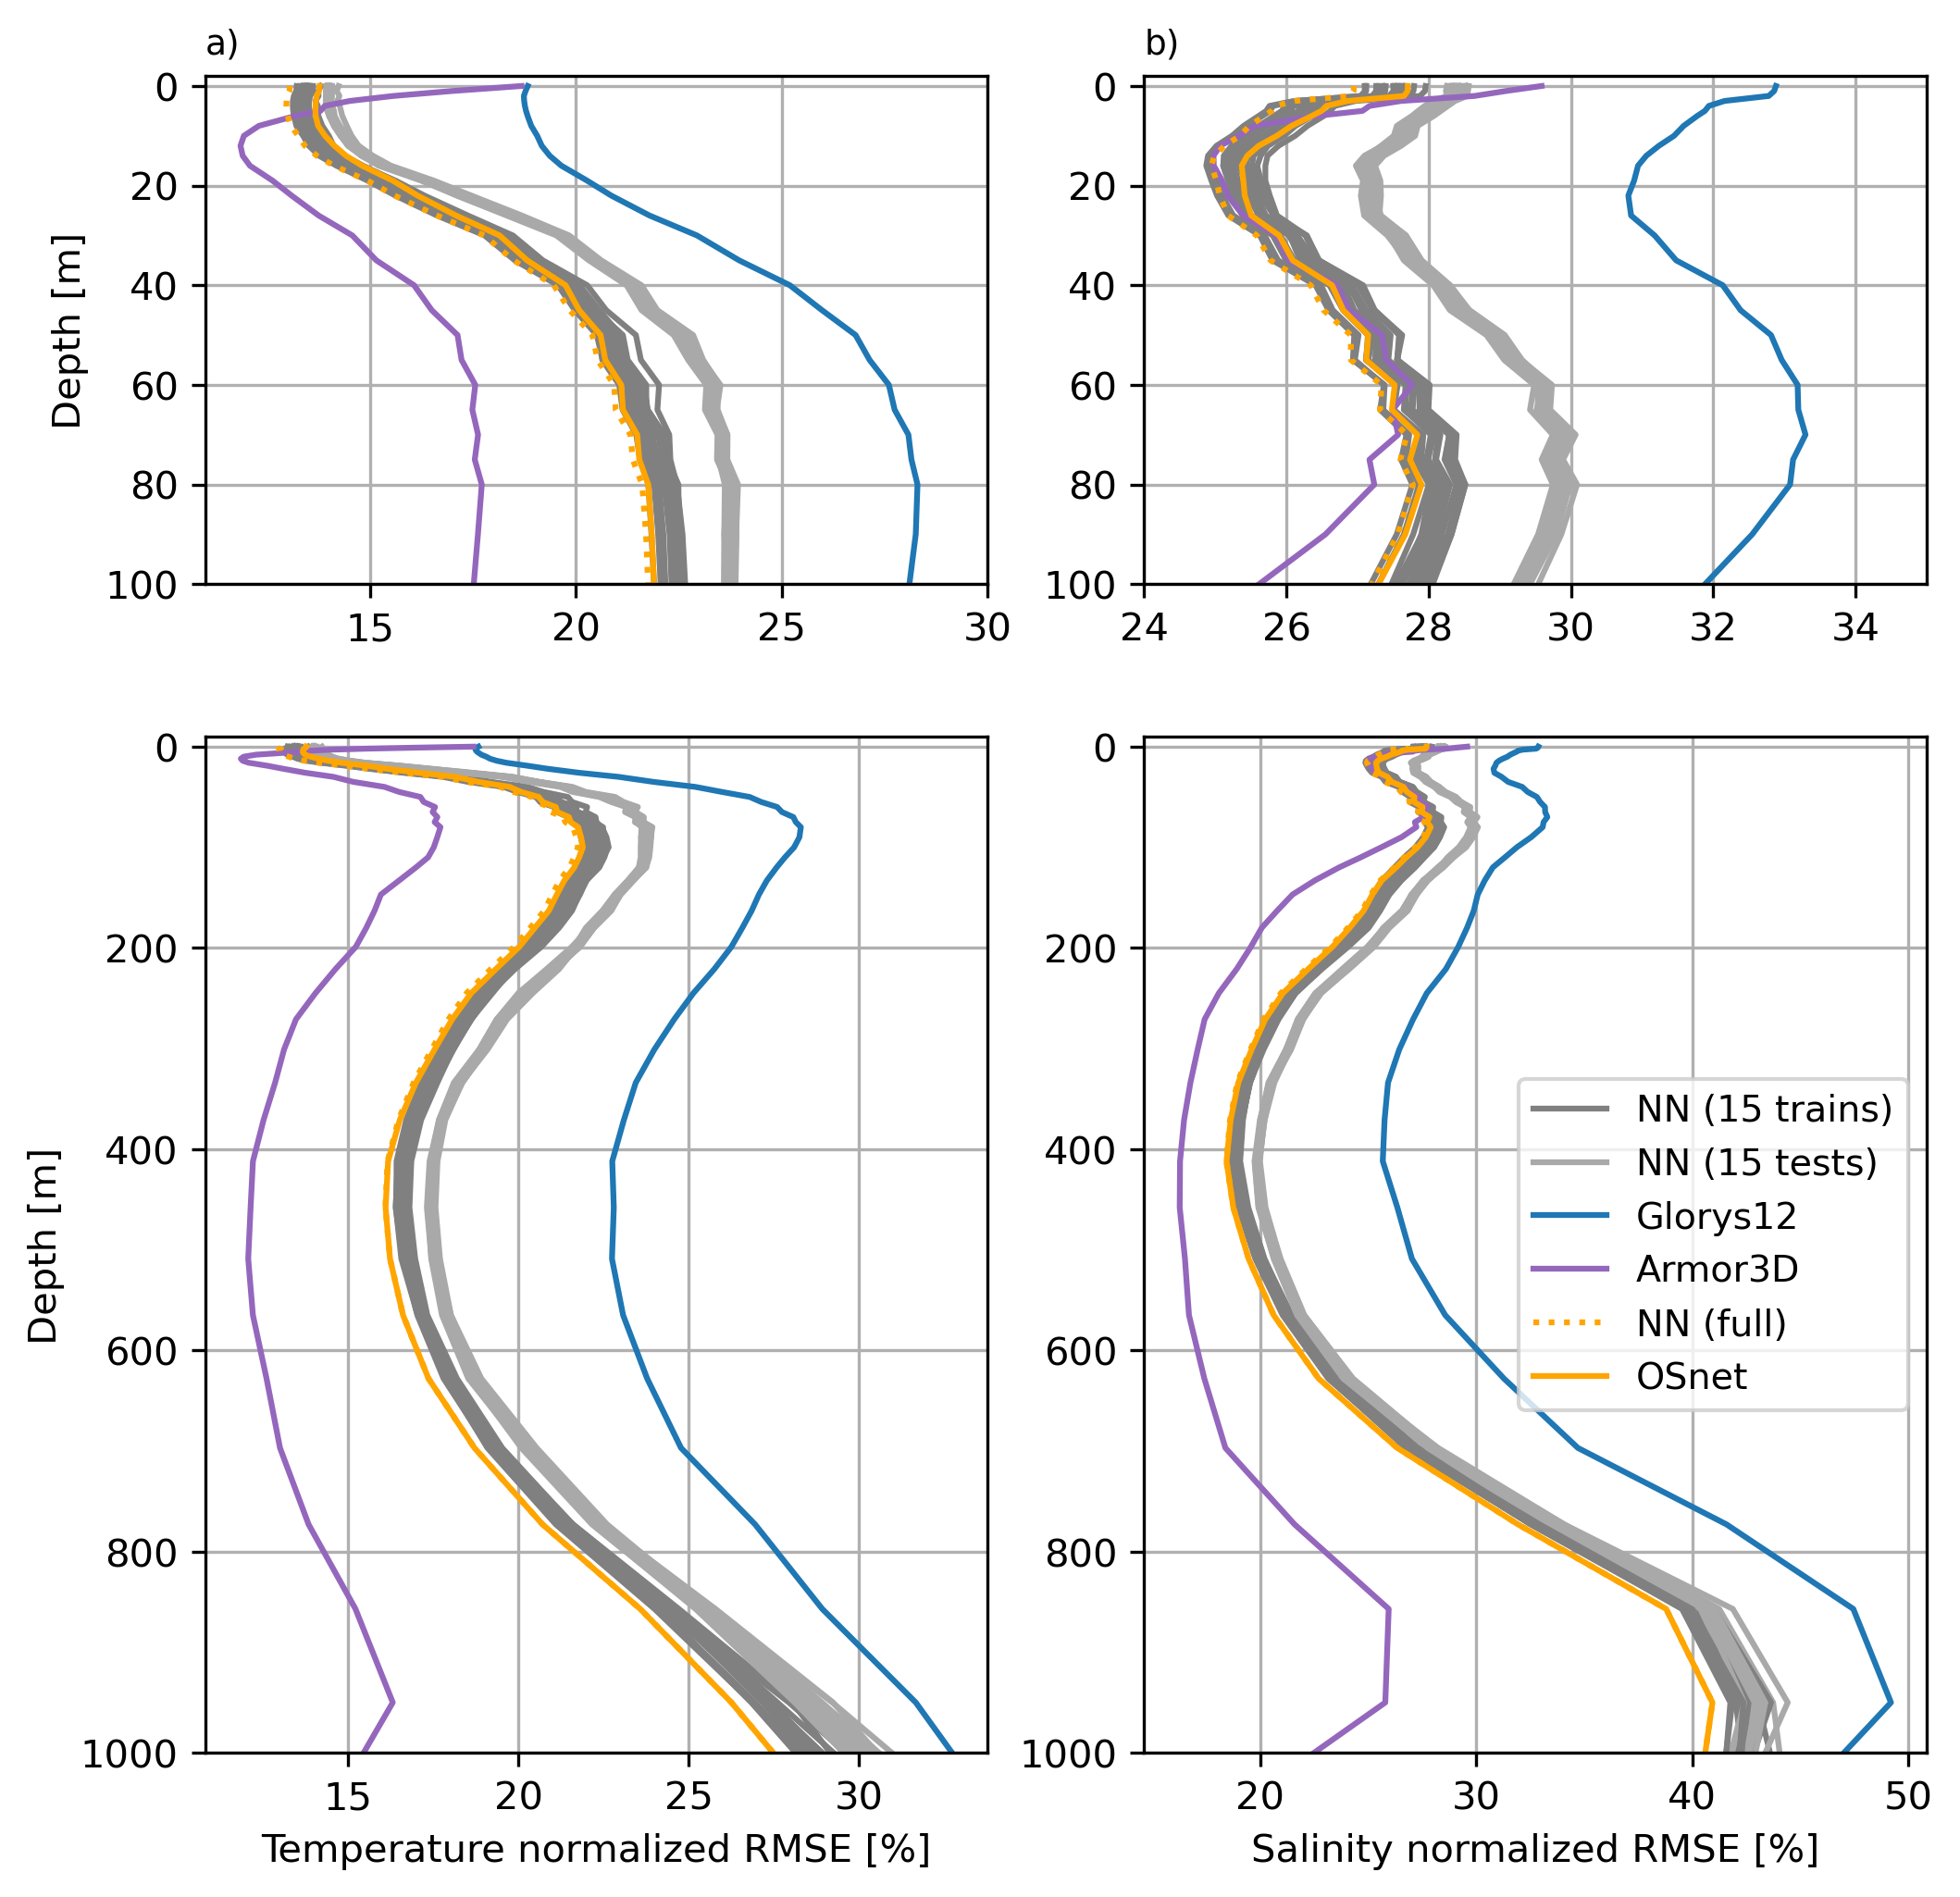

In [11]:
#Plot RMSE profiles
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), gridspec_kw={'height_ratios': [1, 2]}, dpi=300, facecolor='w', edgecolor='k')
dmax = [100,1000]
dmin = [-2,-10]

for l in np.arange(2):
    for m in np.arange(15):
        ax[l,0].plot((ds_train.rmse_T_model.isel(Model = m)*100/ds.TEMP.std(dim = 'N_PROF')), ds_train.PRES_INTERPOLATED,c = 'grey')
        ax[l,0].plot((ds_test.rmse_T_model.isel(Model = m)*100/ds.TEMP.std(dim = 'N_PROF')), ds_test.PRES_INTERPOLATED,c = 'darkgrey')
    ax[l,0].plot((glorys.rmse_T*100/ds.TEMP.std(dim = 'N_PROF')), glorys.PRES_INTERPOLATED, label='Glorys12',c = 'tab:blue')
    ax[l,0].plot((armor.rmse_T*100/ds.TEMP.std(dim = 'N_PROF')), armor.PRES_INTERPOLATED, label='Armor3D',c = 'tab:purple')
    ax[l,0].plot((ds.rmse_T_pred*100/ds.TEMP.std(dim = 'N_PROF')), ds.PRES_INTERPOLATED, label='NN (full)',linestyle = 'dotted',c = 'orange')
    ax[l,0].plot((ds.rmse_T_adj*100/ds.TEMP.std(dim = 'N_PROF')), ds.PRES_INTERPOLATED, label='OSnet',c = 'orange')
    ax[0,0].set_xlim([11,30])
    ax[l,0].set_ylim([dmax[l],dmin[l]])

    ax[l,1].plot((ds_train.rmse_S_model.isel(Model = 0)*100/ds.PSAL.std(dim = 'N_PROF')), ds_train.PRES_INTERPOLATED, label='NN (15 trains)',c = 'grey')
    ax[l,1].plot((ds_test.rmse_S_model.isel(Model = 0)*100/ds.PSAL.std(dim = 'N_PROF')), ds_test.PRES_INTERPOLATED, label='NN (15 tests)',c = 'darkgrey')
    for m in np.arange(1,15):
        ax[l,1].plot((ds_train.rmse_S_model.isel(Model = m)*100/ds.PSAL.std(dim = 'N_PROF')), ds_train.PRES_INTERPOLATED,c = 'grey')
        ax[l,1].plot((ds_test.rmse_S_model.isel(Model = m)*100/ds.PSAL.std(dim = 'N_PROF')), ds_test.PRES_INTERPOLATED,c = 'darkgrey')
    ax[l,1].plot((glorys.rmse_S*100/ds.PSAL.std(dim = 'N_PROF')), glorys.PRES_INTERPOLATED, label='Glorys12',c = 'tab:blue')
    ax[l,1].plot((armor.rmse_S*100/ds.PSAL.std(dim = 'N_PROF')), armor.PRES_INTERPOLATED, label='Armor3D',c = 'tab:purple')
    ax[l,1].plot((ds.rmse_S_pred*100/ds.PSAL.std(dim = 'N_PROF')), ds.PRES_INTERPOLATED, label='NN (full)',linestyle = 'dotted',c = 'orange')
    ax[l,1].plot((ds.rmse_S_adj*100/ds.PSAL.std(dim = 'N_PROF')), ds.PRES_INTERPOLATED, label='OSnet',c = 'orange')
    ax[l,1].set_ylim([dmax[l],dmin[l]])
    ax[0,1].set_xlim([24,35])

ax[0,0].set_title('a)',fontsize = 9,loc = 'left')
ax[0,1].set_title('b)',fontsize = 9,loc = 'left')
ax[1,0].set_xlabel('Temperature normalized RMSE [%]')
ax[1,1].set_xlabel('Salinity normalized RMSE [%]')
ax[1,1].legend(loc = 'best', prop={'size': 9.5})
for t in np.arange(2):
    ax[t,0].set_ylabel('Depth [m]')
    for s in np.arange(2):
        ax[t,s].grid()
ax[1,1].set_ylabel('')

plt.savefig(pathfig + 'RMSEnorm_full.png', transparent=False)
plt.show()

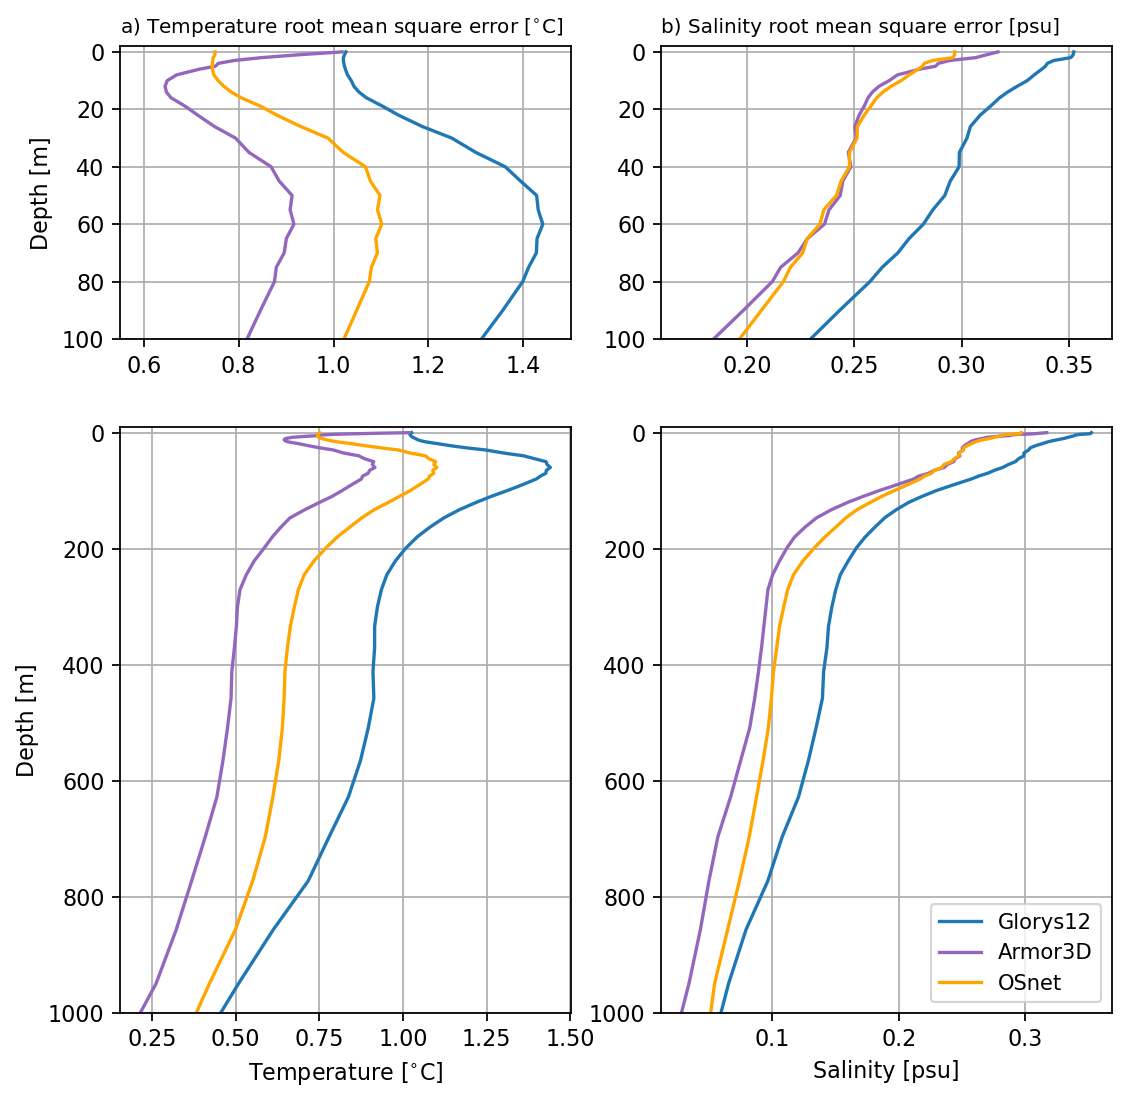

In [12]:
#Plot RMSE profiles
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), gridspec_kw={'height_ratios': [1, 2]}, dpi=160, facecolor='w', edgecolor='k')
dmax = [100,1000]
dmin = [-2,-10]

for l in np.arange(2):
    ax[l,0].plot(glorys.rmse_T, glorys.PRES_INTERPOLATED, label='Glorys12',c = 'tab:blue')
    ax[l,0].plot(armor.rmse_T, armor.PRES_INTERPOLATED, label='Armor3D',c = 'tab:purple')
    ax[l,0].plot(ds.rmse_T_adj, ds.PRES_INTERPOLATED, label='OSnet',c = 'orange')
    ax[0,0].set_xlim([0.55,1.5])
    ax[l,0].set_ylim([dmax[l],dmin[l]])

    ax[l,1].plot(glorys.rmse_S, glorys.PRES_INTERPOLATED, label='Glorys12',c = 'tab:blue')
    ax[l,1].plot(armor.rmse_S, armor.PRES_INTERPOLATED, label='Armor3D',c = 'tab:purple')
    ax[l,1].plot(ds.rmse_S_adj, ds.PRES_INTERPOLATED, label='OSnet',c = 'orange')
    ax[l,1].set_ylim([dmax[l],dmin[l]])
    ax[0,1].set_xlim([0.16,0.37])

ax[0,0].set_title('a) Temperature root mean square error [$^{\circ}$C]',fontsize = 9,loc = 'left')
ax[0,1].set_title('b) Salinity root mean square error [psu]',fontsize = 9,loc = 'left')
ax[1,0].set_xlabel('Temperature [$^{\circ}$C]')
ax[1,1].set_xlabel('Salinity [psu]')
ax[1,1].legend(loc = 'best', prop={'size': 9.5})
for t in np.arange(2):
    ax[t,0].set_ylabel('Depth [m]')
    for s in np.arange(2):
        ax[t,s].grid()
ax[1,1].set_ylabel('')

plt.savefig(pathfig + 'RMSE_simple.png', transparent=False)
plt.show()

In [15]:
ds

<xarray.Dataset>
Dimensions:             (N_PROF: 67767, PRES_INTERPOLATED: 51, Model: 15)
Coordinates:
    LONGITUDE           (N_PROF) float64 -48.43 -47.55 -53.35 ... -61.67 -64.59
    LATITUDE            (N_PROF) float64 49.0 48.73 32.94 ... 43.15 41.81 31.53
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
    TIME                (N_PROF) datetime64[ns] 2001-08-08T06:20:53 ... 2000-...
  * N_PROF              (N_PROF) int64 1 2 3 4 5 ... 67764 67765 67766 67767
Dimensions without coordinates: Model
Data variables: (12/48)
    TEMP_SURF           (N_PROF, PRES_INTERPOLATED) float64 nan nan ... 6.925
    PSAL_SURF           (N_PROF, PRES_INTERPOLATED) float64 nan nan ... 35.03
    TEMP                (N_PROF, PRES_INTERPOLATED) float64 12.44 ... 6.925
    PSAL                (N_PROF, PRES_INTERPOLATED) float64 33.82 ... 35.03
    DC_REFERENCE        (N_PROF) |S8 b'25563' b'25590' ... b'51533584'
    PLATFORM_NUMBER     (N_PROF) |S8 b'4900190' b'4900191' ... b'AGOR'
    ...                  ...
    rmse_T_adj          (PRES_INTERPOLATED) float64 0.7506 0.7499 ... 0.3827
    rmse_S_adj          (PRES_INTERPOLATED) float64 0.2968 0.2967 ... 0.05164
    ae_T_pred           (N_PROF, PRES_INTERPOLATED) float64 0.2182 ... 0.3784
    ae_S_pred           (N_PROF, PRES_INTERPOLATED) float64 0.2046 ... 0.0933
    rmse_T_pred         (PRES_INTERPOLATED) float64 0.7112 0.7107 ... 0.3827
    rmse_S_pred         (PRES_INTERPOLATED) float64 0.2887 0.2886 ... 0.05164